In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import PIL
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
import random
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf

from numpy import save
from numpy import load

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow import keras
from tensorflow.keras import Input, Model

from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten

In [2]:
X = load('G:/Desktop/cat dog/data100(3).npy')
y = load('G:/Desktop/cat dog/y100(3).npy')

In [3]:
y = y.reshape(45091,1)
y = y.flatten()

In [4]:
x_train = X[:36000]
y_train = y[:36000]
x_dev = X[36000:40500]
y_dev = y[36000:40500]
x_test = X[40500:]
y_test = y[40500:]

In [5]:
x_train.shape,y_train.shape,x_dev.shape,y_dev.shape,x_test.shape,y_test.shape

((36000, 128, 128, 3),
 (36000,),
 (4500, 128, 128, 3),
 (4500,),
 (4591, 128, 128, 3),
 (4591,))

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dev_dataset = tf.data.Dataset.from_tensor_slices((x_dev, y_dev))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [7]:
def format_example(image, label):
    image = tf.cast(image, tf.float32)
    return image, label

In [8]:
train = train_dataset.map(format_example)
validation = dev_dataset.map(format_example)
test = test_dataset.map(format_example)

In [9]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [10]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

TensorShape([64, 128, 128, 3])

In [11]:
IMG_SHAPE = (128, 128, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [12]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 2, 2, 2048)


In [13]:
base_model.trainable = False

In [14]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)


(64, 2048)


In [16]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


(64, 1)


In [17]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])


In [18]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

In [19]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2, 2, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [20]:
len(model.trainable_variables)

2

In [21]:
initial_epochs = 30
validation_steps=20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)


20/20 [==============================] - 4s 193ms/step - loss: 0.8976 - accuracy: 0.5945


In [22]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.90
initial accuracy: 0.59


In [23]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Train for 563 steps, validate for 71 steps
Epoch 1/30
563/563 [==============================] - 75s 133ms/step - loss: 0.6450 - accuracy: 0.6204 - val_loss: 0.3647 - val_accuracy: 0.8678
Epoch 2/30
563/563 [==============================] - 72s 128ms/step - loss: 0.5672 - accuracy: 0.7033 - val_loss: 0.3519 - val_accuracy: 0.8831
Epoch 3/30
323/563 [================>.............] - ETA: 27s - loss: 0.5365 - accuracy: 0.7346

KeyboardInterrupt: 

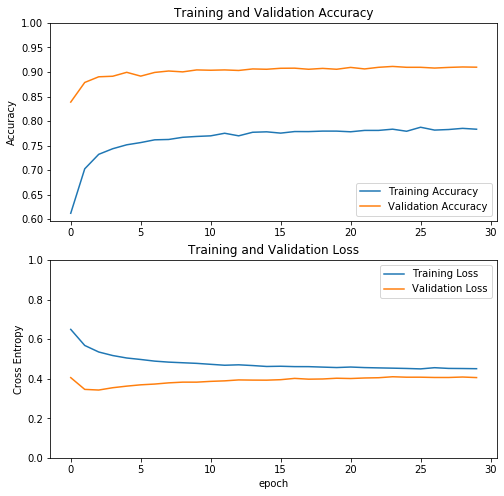

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [25]:
base_model.trainable = True

In [26]:
len(base_model.layers)

311

In [27]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 200

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False


Number of layers in the base model:  311


In [28]:
model.compile(loss=tf.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])
    

In [29]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2, 2, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 14,806,337
Non-trainable params: 6,998,496
_________________________________________________________________


In [30]:
len(model.trainable_variables)


68

In [31]:
%%time
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data=validation_batches)
    

Train for 563 steps, validate for 71 steps
Epoch 30/40
563/563 [==============================] - 121s 215ms/step - loss: 0.3671 - accuracy: 0.8322 - val_loss: 0.3828 - val_accuracy: 0.9036
Epoch 31/40
563/563 [==============================] - 108s 191ms/step - loss: 0.2565 - accuracy: 0.8891 - val_loss: 0.3973 - val_accuracy: 0.9173
Epoch 32/40
563/563 [==============================] - 108s 192ms/step - loss: 0.1941 - accuracy: 0.9203 - val_loss: 0.4020 - val_accuracy: 0.9189
Epoch 33/40
563/563 [==============================] - 107s 191ms/step - loss: 0.1515 - accuracy: 0.9406 - val_loss: 0.4549 - val_accuracy: 0.9173
Epoch 34/40
563/563 [==============================] - 108s 191ms/step - loss: 0.1182 - accuracy: 0.9539 - val_loss: 0.4617 - val_accuracy: 0.9218
Epoch 35/40
563/563 [==============================] - 108s 192ms/step - loss: 0.0925 - accuracy: 0.9667 - val_loss: 0.4764 - val_accuracy: 0.9216
Epoch 36/40
563/563 [==============================] - 109s 193ms/step - lo

In [32]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


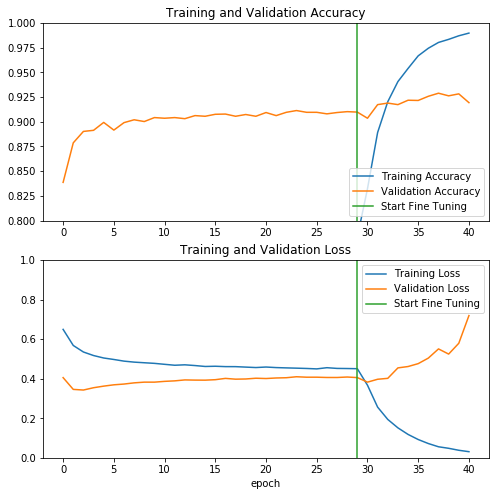

In [33]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [34]:
model.evaluate(validation_batches), model.evaluate(test_batches)

72/72 [==============================] - 12s 169ms/step - loss: 0.7209 - accuracy: 0.9079


([0.7193925146695593, 0.91933334], [0.7208568371004529, 0.9078632])

In [35]:
model.evaluate(validation_batches), model.evaluate(test_batches)

72/72 [==============================] - 8s 111ms/step - loss: 0.6841 - accuracy: 0.9168


([0.6419124876306406, 0.9262222], [0.6840662437025458, 0.9167937])

In [33]:
model.evaluate(validation_batches), model.evaluate(test_batches)

72/72 [==============================] - 7s 95ms/step - loss: 0.1618 - accuracy: 0.9519


([0.14030188927426934, 0.9573333], [0.1618020622085573, 0.95186234])

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,863,873
Non-trainable params: 395,392
_________________________________________________________________


In [35]:
model.save('G:/Desktop/cat dog/simple_fine_tuning(95%).h5')